# Sentiment Analysis: Lairs

This file uses my pickle to store all of the previously organized data from DataFromDen File. In the mypickle file has a dataframe for every lair, inside each datafram contains all the contents and information from each individual post. Such as who was the author, site rep, whether or not the post was upvoted or downvoted and many other bits of information that could be very useful in further analysis. 

For now, we will primarily look at sentiments score across all lairs, the most frequently used words, and a general trendlin just to get an idea of the data. 

### Imports

In [1]:
import pandas as pd
import re, string, unicodedata
import warnings
import matplotlib.pyplot as plt
import numpy as np
    
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.set_option('display.max_colwidth', -1)

### Read in the data

In [2]:
#Import the dictionary containing lair dataframes
import pickle
pickle_in = open("mypickle.pickle","rb")
example_dict = pickle.load(pickle_in)

#Function to return dataframe of lair by name
def LairPostGetter(Lair_name):
    return example_dict[Lair_name]

### Functions to clean data

In [3]:
def clean_content(df):
    """
    Cleans up the column by removing incidents of '\r', '\n' and, '\n\n' in a dataframe
    simply pass in a dataframe with 'content column'
    """
    df['content'] = df['content'].apply(lambda x: x.replace('\n',' ')) 
    df['content'] = df['content'].apply(lambda x: x.replace('\r',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('\n\n',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('\r\n',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('34',' '))
    df['content'] = df['content'].apply(lambda x: x.replace('39',' '))
    
    return df

In [4]:

import html.parser as htmlparser
parser = htmlparser.HTMLParser()

def clean_comments(df):

    df = df.apply(str)
    df = df.apply(parser.unescape)
    df = df.apply(str)
    df = df.apply(expand_contractions)
    df = df.apply(str)
    df = df.apply(clean_string)
    df = pd.DataFrame(df)
    df.columns =['content']
    df = df[df != 'nan']
    df = clean_content(df)
    
    return df

In [5]:
def clean_string(string):
    """
    Removes unsightly html code in a given string
    """
    string = string.lower()
    string = re.sub(r"http\S+", "", string)
#     clean0 = re.compile(r'</code></pre>')
#     out = re.sub(clean0,' ', string)
    clean = re.compile('<.*?>')
    out = re.sub(clean,' ', string)
    clean1 = r'^https?:\/\/.*[\r\n]*'
    out = re.sub(clean1,' ', out)
    clean2 = re.compile(r'[^\w\s]')
    out = re.sub(clean2,' ', out)
    return out

In [6]:
# dictionary of all possible contractions
CONTRACTION_MAP = {
"ain't": "is not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",
"could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not",
"doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
"haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he he will have",
"he's": "he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would",
"I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have","i'd": "i would",
"i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have","isn't": "is not",
"it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have","it's": "it is",
"let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
"oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
"she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
"should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have",
"so's": "so as","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would",
"there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have",
"they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have",
"wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have",
"we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have",
"what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
"where'd": "where did","where's": "where is","where've": "where have","who'll": "who will",
"who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
"will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would",
"y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would",
"you'd've": "you would have","you'll": "you will","you'll've": "you will have","you're": "you are","you've": "you have"
}

# function to expand contractions in text
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    """
    Expands any contractions within a given string
    """

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

### Cleaning up Comments

### As an example we will look at the sentiment score of one Lair, here we are looking at the lair named "covid19"

In [7]:
df_original = LairPostGetter("covid19")
df_original

,url,contentType,content,author_id,author_displayName,author_siteRep,author_lairRep,author_isBot,lair_id,lair_name,lair_displayName,stats_score,stats_upVoteScore,stats_downVoteScore,stats_upVoters,stats_views,stats_replyCount,stats_trendingScoreMultiplier,stats_weightedScore,stats_mtrBoost
0,/l/covid19/i2f5HtL6C2/pfizer-biontech-moderns-vaccine-components/?r=lCRgOJDjlz,reply,"<p>Self-reported speculative side effects, not side effects that were shown under controlled conditions.</p>\n<p>I&#39;m not dismissing it wholesale even though it may sound that way. I do hold confirmed and reputably peer-reviewed science over speculative assumption. Those cases should be investigated and the results should be published, of course. Of there&#39;s some side effect that&#39;s weird I&#39;d like to know about it, absolutely. </p>\n<p>That database doesn&#39;t scare me away personally though.</p>",33ae5b6690d14b9985abd530b281fafb,dis7ant,98.34,0,False,72e69a5313b9434f9fd378d5087bd3d9,covid19,Coronavirus,0,0,0,0,0,0,20.0000,0.000,0
1,/l/covid19/i2f5HtL6C2/pfizer-biontech-moderns-vaccine-components/?r=3BPEJOoeSt,reply,"<p>If you check the picture, it shows that around 14% of all side effects are SERIOUS NERVOUS SYSTEM disorder. </p>\n<p><a href=""https://twitter.com/NikolovScience/status/1367266480761438208?s=09"" target=""_blank"" rel=""nofollow noopener"">https://twitter.com/NikolovScience/status/1367266480761438208?s=09</a> </p>\n<p><a href=""https://twitter.com/DocRoger/status/1367282828552138752?s=19"" target=""_blank"" rel=""nofollow noopener"">https://twitter.com/DocRoger/status/1367282828552138752?s=19</a></p>",dc01d28a88474e5598b797287c14eb2e,Pumpers,97.39,0,False,72e69a5313b9434f9fd378d5087bd3d9,covid19,Coronavirus,0,0,0,0,0,1,20.0000,0.000,0
2,/l/covid19/i2f5HtL6C2/pfizer-biontech-moderns-vaccine-components/?r=tJ1WfKezQ7,reply,"<p>this is from the database curators that the other list of side effects sites, just for reference and perspective.</p>",33ae5b6690d14b9985abd530b281fafb,dis7ant,98.34,0,False,72e69a5313b9434f9fd378d5087bd3d9,covid19,Coronavirus,0,0,0,0,1,0,20.0000,0.000,0
3,/l/covid19/i2f5HtL6C2/pfizer-biontech-moderns-vaccine-components/?r=WOX5c5DE0W,reply,"<p>meh, I&#39;m less worried about parts of a virus than a whole virus, this is basically hacking the way that viruses reproduce to instead produce just the viral spikes. </p>\n<p>to me, it&#39;s way safer. personal opinion though.</p>",33ae5b6690d14b9985abd530b281fafb,dis7ant,98.34,0,False,72e69a5313b9434f9fd378d5087bd3d9,covid19,Coronavirus,0,0,0,0,0,1,20.0000,0.000,0
4,/l/covid19/i2f5HtL6C2/pfizer-biontech-moderns-vaccine-components/?r=06DFiinzjC,reply,"<p>I am just a little worried with the long term side effects from these ( Pfizer and Moderna) that uses mRNA technology, which is quite new.</p>",dc01d28a88474e5598b797287c14eb2e,Pumpers,97.39,0,False,72e69a5313b9434f9fd378d5087bd3d9,covid19,Coronavirus,0,0,0,0,4,2,20.0000,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,/l/covid19/30kHliQMll/so-i-got-covid-and-what-is-my-feedback-so-far/?r=hLRBh8aBJj,reply,"<p>31/01 - the burning smell feeling is almost gone, not sure if because I lost almost 100% of smell or because I got used to it. Still got 100% of taste though, Yesterday everything were slightly bitter, even chocolate and honey, but today is 100% as always.</p>\n<p>Still coughing a lot, with mucus, sometimes white, sometimes green/yellow.</p>\n<p>37,1°C &#34;fever&#34;</p>\n<p>The body is slightly heavy, but could be my laziness.</p>\n<p>No headache, no breathing issues, just a minor discomfort on my mid back.</p>",dc01d28a88474e5598b797287c14eb2e,Pumpers,97.39,0,False,72e69a5313b9434f9fd378d5087bd3d9,covid19,Coronavirus,0,0,0,0,0,0,0.0001,0.000,0
96,/l/covid19/30kHliQMll/so-i-got-covid-and-what-is-my-feedback-so-far/?r=Mz5nSMpiuF,reply,"<p>I&#39;m feeling just like a hangover, tks.</p>",dc01d28a88474e5598b797287c14eb2e,Pumpers,97.39,0,False,72e69a5313b9434f9fd378d5

### Clean all comments in the "covid19" lair

In [8]:
#This will clean all of the comments so they can be easily tokenized and ready for ntlk processing
df_original = df_original['content']
df= clean_comments(df_original)
df

,content
0,self reported speculative side effects not side effects that were shown under controlled conditions i am not dismissing it wholesale even though it may sound that way i do hold confirmed and reputably peer reviewed science over speculative assumption those cases should be investigated and the results should be published of course of there is some side effect that is weird i would like to know about it absolutely that database does not scare me away personally though
1,if you check the picture it shows that around 14 of all side effects are serious nervous system disorder
2,this is from the database curators that the other list of side effects sites just for reference and perspective
3,meh i am less worried about parts of a virus than a whole virus this is basically hacking the way that viruses reproduce to instead produce just the viral spikes to me it is way safer personal opinion though
4,i am just a little worried with the long term side effects from these pfizer and moderna that uses mrna technology which is quite new
...,...
95,31 01 the burning smell feeling is almost gone not sure if because i lost almost 100 of smell or because i got used to it still got 100 of taste though yesterday everything were slightly bitter even chocolate and honey but today is 100 as always still coughing a lot with mucus sometimes white sometimes green yellow 37 1 c fever the body is slightly heavy but could be my laziness no headache no breathing issues just a minor discomfort on my mid back
96,i am feeling just like a hangover tks
97,i hope you feel better heard of to many people passing away lately 144
98,i got covid on last saturday and i am pretty sure about the date because it was my only exposure bad luck i guess so on sunday i had a small headache but i think it was unrelated on monday i had no symptoms on tuesday i woke 100 but around 10pm i started feeling some chills like a regular cold on wednesday i was fine when i woke but during the morning i started with 37 2 to 37 9 fever an cough went to the company doctor he prescribed me some meds and schedule the test for friday on thursday i was kind of tired a lot of cough fever every now and then on friday i got the positive result still same symptoms today saturday i am still coughing a lot but no fever but i lost the smell still got the taste though i have a weird constant burning smell feeling like camp fire or that toasted barrel note on some peated whiskys no major aches or any breading issues i will keep a daily log here if you do not mind just for reference


### Running sentiment analysis on Comments in Lair

### Imports

In [9]:

######
#import natural language toolkit
!pip install nltk
import nltk
nltk.download('vader_lexicon') 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()
from nltk.probability import FreqDist
import string

## import word tokenizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

# get lexicon 


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chang\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Sentiment Analysis of Positive and Negative Scores 

In [10]:
#specify dataframe here
nltk_data = df

# tokenize, stem, and remove stop words
nltk_data['token'] = nltk_data['content'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
nltk_data['stop'] = nltk_data['token'].apply(lambda x: [item for item in x if item not in stop_words])
nltk_data['stem'] = nltk_data['stop'].apply(lambda x: [ps.stem(y) for y in x])
stem_nltk_data = nltk_data['stem'].apply(pd.Series).stack()

# calculate word frequency
fdist_nltk_data = FreqDist(stem_nltk_data)

# remove punctuation counts
for punc in string.punctuation:
    del fdist_nltk_data[punc]

# get list of the 'content' (responses) 
nltk_data_list = list(nltk_data['content'].values)

### Most Frequently Used Words across 

In [11]:
# get list of the 'content' (responses) 
fdist_nltk_data

FreqDist({'vaccin': 85, 'peopl': 63, 'covid': 52, 'test': 37, 'viru': 32, 'pandem': 32, 'would': 30, 'us': 30, 'countri': 30, 'said': 29, ...})

## Plot Frequency 

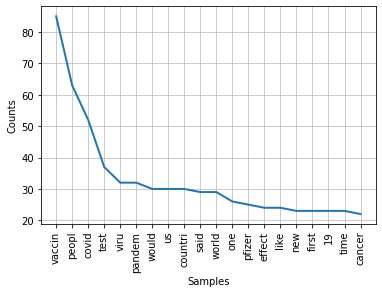

In [12]:
# Frequency Distribution Plot - top 20
# run cell twice if freq dist plot doesn't appear
fdist_nltk_data.plot(20, cumulative=False);

In [13]:
# create function that will output dataframe 
# that stores sentiment information
def get_sentiments(input_list):
    """
    output dataframe that stores sentiment information
    """
    output = pd.DataFrame()
    
    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)

    return output

In [14]:
def get_mean(df):
    compound = df['compound'].mean()
    return compound

In [15]:
# use the get sentiments function on nltk processed joe data
nltk_data_sentiments = get_sentiments(nltk_data_list)


In [16]:
# drop token and stop columns for nltk data and create pos, neg, neu, compound columns
nltk_data_sent = nltk_data.drop(['token','stop'],axis=1)\
.assign(pos=nltk_data_sentiments['pos'])\
.assign(neg=nltk_data_sentiments['neg'])\
.assign(neu=nltk_data_sentiments['neu'])\
.assign(compound=nltk_data_sentiments['compound'])

nltk_data_sent.head()

,content,stem,pos,neg,neu,compound
0,self reported speculative side effects not side effects that were shown under controlled conditions i am not dismissing it wholesale even though it may sound that way i do hold confirmed and reputably peer reviewed science over speculative assumption those cases should be investigated and the results should be published of course of there is some side effect that is weird i would like to know about it absolutely that database does not scare me away personally though,"[self, report, specul, side, effect, side, effect, shown, control, condit, dismiss, wholesal, even, though, may, sound, way, hold, confirm, reput, peer, review, scienc, specul, assumpt, case, investig, result, publish, cours, side, effect, weird, would, like, know, absolut, databas, scare, away, person, though]",0.100,0.021,0.879,0.6402
1,if you check the picture it shows that around 14 of all side effects are serious nervous system disorder,"[check, pictur, show, around, 14, side, effect, seriou, nervou, system, disord]",0.000,0.276,0.724,-0.6249
2,this is from the database curators that the other list of side effects sites just for reference and perspective,"[databas, curat, list, side, effect, site, refer, perspect]",0.000,0.000,1.000,0.0000
3,meh i am less worried about parts of a virus than a whole virus this is basically hacking the way that viruses reproduce to instead produce just the viral spikes to me it is way safer personal opinion though,"[meh, less, worri, part, viru, whole, viru, basic, hack, way, virus, reproduc, instead, produc, viral, spike, way, safer, person, opinion, though]",0.072,0.082,0.846,0.1513
4,i am just a little worried with the long term side effects from these pfizer and moderna that uses mrna technology which is quite new,"[littl, worri, long, term, side, effect, pfizer, moderna, use, mrna, technolog, quit, new]",0.000,0.080,0.920,-0.2280


### Here we can look at some of the nltk sentiment score for each sentence in the "covid19" lair

In [17]:
# use the get sentiments function on nltk processed  Lair data
nltk_data_sentiments = get_sentiments(nltk_data_list)
nltk_data_sentiments.head()

,compound,neg,neu,pos,sentence
0,0.6402,0.021,0.879,0.100,self reported speculative side effects not side effects that were shown under controlled conditions i am not dismissing it wholesale even though it may sound that way i do hold confirmed and reputably peer reviewed science over speculative assumption those cases should be investigated and the results should be published of course of there is some side effect that is weird i would like to know about it absolutely that database does not scare me away personally though
1,-0.6249,0.276,0.724,0.000,if you check the picture it shows that around 14 of all side effects are serious nervous system disorder
2,0.0000,0.000,1.000,0.000,this is from the database curators that the other list of side effects sites just for reference and perspective
3,0.1513,0.082,0.846,0.072,meh i am less worried about parts of a virus than a whole virus this is basically hacking the way that viruses reproduce to instead produce just the viral spikes to me it is way safer personal opinion though
4,-0.2280,0.080,0.920,0.000,i am just a little worried with the long term side effects from these pfizer and moderna that uses mrna technology which is quite new


In [18]:
# The stats of the sentiments from this lair
nltk_data_sentiments.describe()

,compound,neg,neu,pos
count,100.000000,100.000000,100.000000,100.000000
mean,0.046763,0.081260,0.747650,0.111090
std,0.571552,0.104234,0.249545,0.144678
min,-0.999600,0.000000,0.000000,0.000000
25%,-0.356550,0.000000,0.713000,0.000000
50%,0.000000,0.052000,0.806500,0.069500
75%,0.477325,0.138250,0.895000,0.153000
max,0.987600,0.636000,1.000000,0.756000


In [19]:
# drop token and stop columns for nltk data and create pos, neg, neu, compound columns
nltk_data_sent.head()

,content,stem,pos,neg,neu,compound
0,self reported speculative side effects not side effects that were shown under controlled conditions i am not dismissing it wholesale even though it may sound that way i do hold confirmed and reputably peer reviewed science over speculative assumption those cases should be investigated and the results should be published of course of there is some side effect that is weird i would like to know about it absolutely that database does not scare me away personally though,"[self, report, specul, side, effect, side, effect, shown, control, condit, dismiss, wholesal, even, though, may, sound, way, hold, confirm, reput, peer, review, scienc, specul, assumpt, case, investig, result, publish, cours, side, effect, weird, would, like, know, absolut, databas, scare, away, person, though]",0.100,0.021,0.879,0.6402
1,if you check the picture it shows that around 14 of all side effects are serious nervous system disorder,"[check, pictur, show, around, 14, side, effect, seriou, nervou, system, disord]",0.000,0.276,0.724,-0.6249
2,this is from the database curators that the other list of side effects sites just for reference and perspective,"[databas, curat, list, side, effect, site, refer, perspect]",0.000,0.000,1.000,0.0000
3,meh i am less worried about parts of a virus than a whole virus this is basically hacking the way that viruses reproduce to instead produce just the viral spikes to me it is way safer personal opinion though,"[meh, less, worri, part, viru, whole, viru, basic, hack, way, virus, reproduc, instead, produc, viral, spike, way, safer, person, opinion, though]",0.072,0.082,0.846,0.1513
4,i am just a little worried with the long term side effects from these pfizer and moderna that uses mrna technology which is quite new,"[littl, worri, long, term, side, effect, pfizer, moderna, use, mrna, technolog, quit, new]",0.000,0.080,0.920,-0.2280


In [20]:
# # Global sentiment score for the whole lair
# joe_global_sentiment = nltk_data_sent["compound"].mean()
# joe_global_sentiment

In [21]:
# see where the most negative message is located
most_negative_index = nltk_data_sent['compound'].argmin()
most_postive_index = nltk_data_sent['compound'].argmax()

In [22]:
# look at the most negative column
nltk_data_sent.loc[[most_negative_index]]


content  \
12   there s a secret layer of information in your cells called messenger rna  that s located between dna and proteins  that serves as a critical link  now  in a medical shocker to the whole world of vaccine philosophy  scientists at sloan kettering found that mrna itself carries cancer causing changes   changes that genetic tests don t even analyze  flying completely under the radar of oncologists across the globe    so now  it s time for independent laboratories that are not vaccine manufacturers  or hired by them  to run diagnostic testing on the covid vaccine series and find out if these are cancer driving inoculations that  once the series is complete  will cause cancer tumors in the vaccinated masses who have all rushed out to get the jab out of fear and propaganda influence  welcome to the world of experimental and dirty vaccines known as mrna  technology      previously unknown cancer driving messengers are hiding in rna  not   dna    this mind blowing discovery should be published on every medical news site  newspaper  television news broadcast and on the cdc website  but unless you are reading this article and use  duckduckg o as your search engine  you probably wouldn t ever see it  that s because  google is in on the fix   with big pharma and the vic   the vaccine industrial complex  so here s a more in depth explanation of what we re looking at  for real  regarding mrna and vaccines    the information carrying molecule  messenger rna  can instruct human cells ultimately in the same way as cancer drivers  playing a major role in causing cancer to thrive while inactivating natural tumor suppressing proteins the human body creates to save you from cancer  this is the complete opposite of what the cdc and the vaccine manufactures are telling everyone right now about the covid vaccines  and this is based on clinical research by molecular biologists at the sloan kettering institute    even sequencing the dna in cancer cells doesn t reveal these changes  that s how sneaky the vaccines are  it s like a  trojan horse  that tells your cells to allow these changes to be made  as if they were safe  but they re not  all assumptions being made about mrna being  safe  right now have been completely turned 180 degrees with this research  consider this very carefully if you have not yet been vaccinated with mrna technology  and you may want to  lawyer up  if you already got the jabs     after your covid vaccination  rna is transported out of your cell s nucleus  and will no longer function properly as a cancer tumor suppressor    bill gates and the vaccine industrial complex are very sinister  as we all know  but to create vaccines that truncate  disable by cutting short  cancer tumor suppressors  and destroy the human body s ability to protect against cancer  well  that s just complete insanity  truncated tumor suppressor proteins are similar to the dna mutations that cause cancer cells to mutate and multiply uncontrollably  will america see cancer cases skyrocket over the next few years due to covid vaccines  only time will tell  but right now  science is revealing that it s likely  pay close attention    therefore  anyone who is scared to death of the covid vaccines is pro science rather than anti science  because the science shows the mrna technology is very dangerous  especially concerning proteins that fuel cancer tumors  let s say that again  science shows mrna technology can fuel cancer tumor growth     substantial amount of people with blood cancer have the same inactivation of tumor suppressor genes at the mrna level    scientists also discovered that a substantial amount of people with blood cancer  a k a  chronic lymphocytic leukemia  cll   have the same exact inactivation of tumor suppressor genes at the mrna level  in fact  the mrna changes they detected could possibly account for the missing dna mutations  and that spells out bad news for everyone who thinks the covid vaccine series is  safe and effective

In [23]:
nltk_data_sent.loc[[most_postive_index]]

content  \
14    why is this alarming     if we go back in history  in the 1930s a model of  technocracy  was created  it involved the great minds of scientists and engineers during that time  they brainstormed during the great depression and realized that capitalism was dead  many people back then where not happy with politicians  even today   these scientists and engineers were obliged to build a new economic model  this model was a   resource based economic system   against a   price based economic system    these professionals believed that it would be so sufficient and so well engineered that it would erased the need for political system whatsoever          image source     back in those days  they proposed for the abolition of congress  and courts because it was not necessary to still exist when they would be taking over and would be running everything  in other words  no political system    people were so hungry of something new  in mid 1940s  after world war ii  the economic system was revived  the industries were starting up again  during this period there were 500 000 people on technocratic movement in canada and the us  these people have this utopian idea of hope believing technocracy would work out    they had no clue that the conclusion of technocracy would be scientific dictatorship    in 1970    zbigniew k  brzezinski  published a book between two ages  americas role in a technetronic era   different name but the same meaning for technocracy  in his book brzezinski suggested that the end scenario of the shape of society would be the technetronic era  keep in mind that  today it comes in different names such as   r  esource based economic system    sustainable development   by the un    green new deal   or climate change    the great reset   by world economic forum   and  agenda 21   all in different names but one agenda   to rule the entire society by advanced science  engineering  and technology          image source     david rockefeller  in 1970s formed a group called  trilateral commission   the goal of the said commission was to discreetly establish a new international economic order  in 2000  an ideology for technocracy was beginning to grow in china  china is very known as an autocratic communist country combined with her technological progress  china today has a social credit score system in place  together with almost a billion surveillance face recognition cameras all over the country  let that sink in a bit        image source     a perfect example of a technocratic dictatorship is the said relocation of hundreds of  millions of farmers  into the cities  by doing that  the regime could take over the lands for the sake of factory farming  also  this move is a cover for an economic  and social engineering  china today is influencing other countries in asia  europe  africa  and north america  ironically  china has perfected technocracy and is now bringing it to other countries to adopt such as canada and the us where technocracy was originally invented  and behold  we got scientific dictatorship on our doorsteps          image source     now  these silicon valley big techs like apple  facebook  google  amazon  twitter  and the like are apparently aggressive controlling society economically  un noticed to many of the people in the world today  these big tech companies are more powerful than a government  the after effect of the big techs controlling and censoring what netizens say or post in their platforms is that people are turning towards these alternative platforms such as uptrennd  d tube  bitchute  brandnewtube  densocial  parler to name a few          image source     in technocracy  there is this called  medical tyranny   whenever we here science says that and that more often from these so called experts  and phds we are then persuaded and easily mind controlled by them  site for example  dr  fauci has said publicy    we need to wear two face masks and we still need to wear face masks even after v

In [24]:
#specify dataframe here
def get_list(df):
    nltk_data = df

    # tokenize
    nltk_data['token'] = nltk_data['content'].apply(word_tokenize)

    # remove stop words using the english language set to column data of stop words
    stop_words = set(stopwords.words('english'))
    nltk_data['removed stop'] = nltk_data['token'].apply(lambda x: [item for item in x if item not in stop_words])

    # Find the stem words in the data
    nltk_data['stem'] = nltk_data['removed stop'].apply(lambda x: [ps.stem(y) for y in x])
    stem_nltk_data = nltk_data['stem'].apply(pd.Series).stack()

    # calculate word frequency
    fdist_stem_words = FreqDist(stem_nltk_data)

    # Not necessary
    # # remove punctuation counts
    # for punc in string.punctuation:
    #     del fdist_nltk_data[punc]

    # get list of the 'content' (responses) 
    nltk_data_list = list(nltk_data['content'].values)
    
    return nltk_data_list


### Looping through all Lairs and getting the compound score each Lair

In [25]:
# This appends the sentiment score for all lairs and appends the mean compound score for each lair
lair_names = ['covid19', 'Cryptocurrency', 'TechNews', 'CrowsNest', 'ama', 'TheBitcoinStreetJournal', 'smaugust', 'Dragonshoard', 'dragonchain-official-it', 'dragonchain-official-nl', 'qanon', 'dragonchain-official-kr', 'memes', 'welcome-to-the-matrix', 'dragonchain-official-fr', 'hello', 'eternal-archive', 'hash', 'redpills', 'ems', 'Dragonchain', 'dragonchain-official-pt', 'Sports', 'maker', 'dance', 'pets', 'music', 'dragonchain-official-es', 'Christianity', 'CreatureComforts', 'politics', 'DragonDen', 'gov2021', 'code', 'bored', 'FourTwenty', 'DenSupport', 'art', 'ISLM', 'DrgnES', 'gaming', 'beaxy', 'FIT', 'TIL', 'LCP', 'lbty', 'Outdoors', 'Hackernoon', 'dragonchain-official-jp']

lair_scores = []

for i in range(len(lair_names)):
    df = LairPostGetter(lair_names[i])
    df = clean_comments(df)
    nltk_data_list = get_list(df)
    sentiments = get_sentiments(nltk_data_list)
    lair_scores.append(get_mean(sentiments))

In [26]:
score_df = pd.DataFrame(list(zip(lair_names, lair_scores)), 
               columns =['Name', 'Compound Score'])
score_df = score_df.sort_values('Compound Score',ascending = False)
score_df

,Name,Compound Score
42,FIT,0.199750
13,welcome-to-the-matrix,0.180230
48,dragonchain-official-jp,0.144575
29,CreatureComforts,0.132185
44,LCP,0.117585
22,Sports,0.099325
11,dragonchain-official-kr,0.099180
17,hash,0.096730
40,gaming,0.096385
15,hello,0.096335


### Graph of Most Positive on the Left and the Most Negative Lairs on the Right

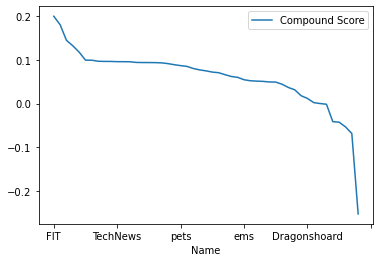

In [27]:

score_df.plot(x = 'Name',y = "Compound Score");

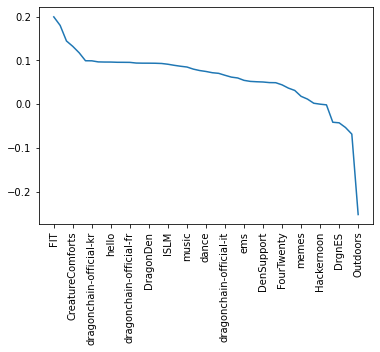

<Figure size 28800x28800 with 0 Axes>

In [28]:
import matplotlib.ticker as ticker
x = score_df['Name'].tolist()
y = score_df['Compound Score'].tolist()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(len(lair_names)))
ax1.plot(x,y)
ax1.set_xticklabels(x)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.figure(figsize=(400,400))
plt.show()


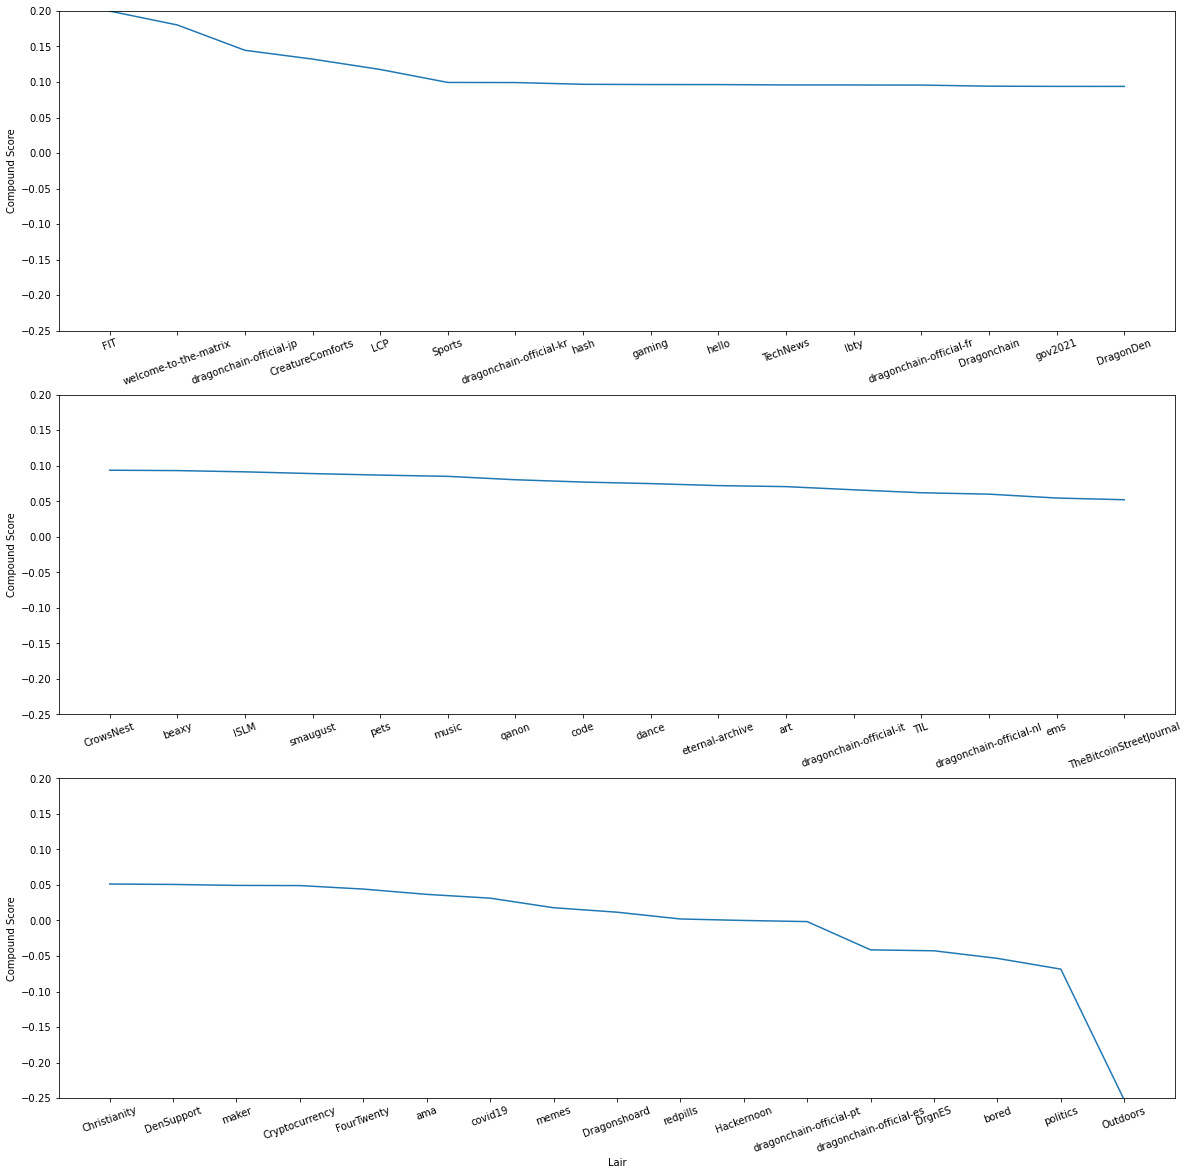

In [29]:
x = score_df['Name'].tolist()
y = score_df['Compound Score'].tolist()

x1= x[0:16]
x2 = x[16:32]
x3 = x[32:49]

y1= y[0:16]
y2 = y[16:32]
y3 = y[32:49]

fig, (ax1, ax2, ax3) = plt.subplots (3, figsize = (20,20))

ax1.plot(x1,y1)
ax1.set_ylim([-0.25, 0.2])
ax1.tick_params(axis='x', labelrotation = 20)
ax1.set_ylabel('Compound Score')

ax2.plot(x2,y2)
ax2.tick_params(axis='x', labelrotation = 20)
ax2.set_ylim([-0.25, 0.2])
ax2.set_ylabel('Compound Score')

ax3.plot(x3,y3)
ax3.tick_params(axis='x', labelrotation = 20)
ax3.set_ylim([-0.25, 0.2]);
ax3.set_ylabel('Compound Score')
ax3.set_xlabel('Lair');

### We can also look at specific users scores for each Lair, Here was are looking at Joes Sentiment Score per Lair.

In [30]:
lair_names = ['covid19', 'Cryptocurrency', 'TechNews', 'CrowsNest', 'ama', 'TheBitcoinStreetJournal', 'smaugust', 'Dragonshoard', 'dragonchain-official-it', 'dragonchain-official-nl', 'qanon', 'dragonchain-official-kr', 'memes', 'welcome-to-the-matrix', 'dragonchain-official-fr', 'hello', 'eternal-archive', 'hash', 'redpills', 'ems', 'Dragonchain', 'dragonchain-official-pt', 'Sports', 'maker', 'dance', 'pets', 'music', 'dragonchain-official-es', 'Christianity', 'CreatureComforts', 'politics', 'DragonDen', 'gov2021', 'code', 'bored', 'FourTwenty', 'DenSupport', 'art', 'ISLM', 'DrgnES', 'gaming', 'beaxy', 'FIT', 'TIL', 'LCP', 'lbty', 'Outdoors', 'Hackernoon', 'dragonchain-official-jp']


lair_user_scores = []
for i in range(len(lair_names)):
    df = LairPostGetter(lair_names[i])
    df = df.loc[df['author_displayName'] == 'J O E D R A G O N']
    df = clean_comments(df)
    nltk_data_list = get_list(df)
    sentiments = get_sentiments(nltk_data_list)
    lair_user_scores.append(get_mean(sentiments))


In [31]:
score_df = pd.DataFrame(list(zip(lair_names, lair_user_scores)), 
               columns =['Name', 'Compound Score'])
score_df = score_df.sort_values('Compound Score',ascending = False)
score_df

,Name,Compound Score
13,welcome-to-the-matrix,0.163075
36,DenSupport,0.130505
31,DragonDen,0.092410
17,hash,0.089095
10,qanon,0.073045
26,music,0.049905
15,hello,0.049780
29,CreatureComforts,0.047790
20,Dragonchain,0.046605
43,TIL,0.045960


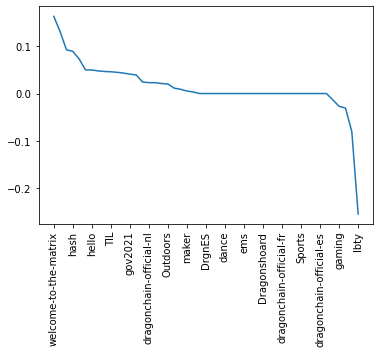

<Figure size 28800x28800 with 0 Axes>

In [32]:
import matplotlib.ticker as ticker
x = score_df['Name'].tolist()
y = score_df['Compound Score'].tolist()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticks(np.arange(len(lair_names)))
ax1.plot(x,y)
ax1.set_xticklabels(x)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))

plt.figure(figsize=(400,400))
plt.show()

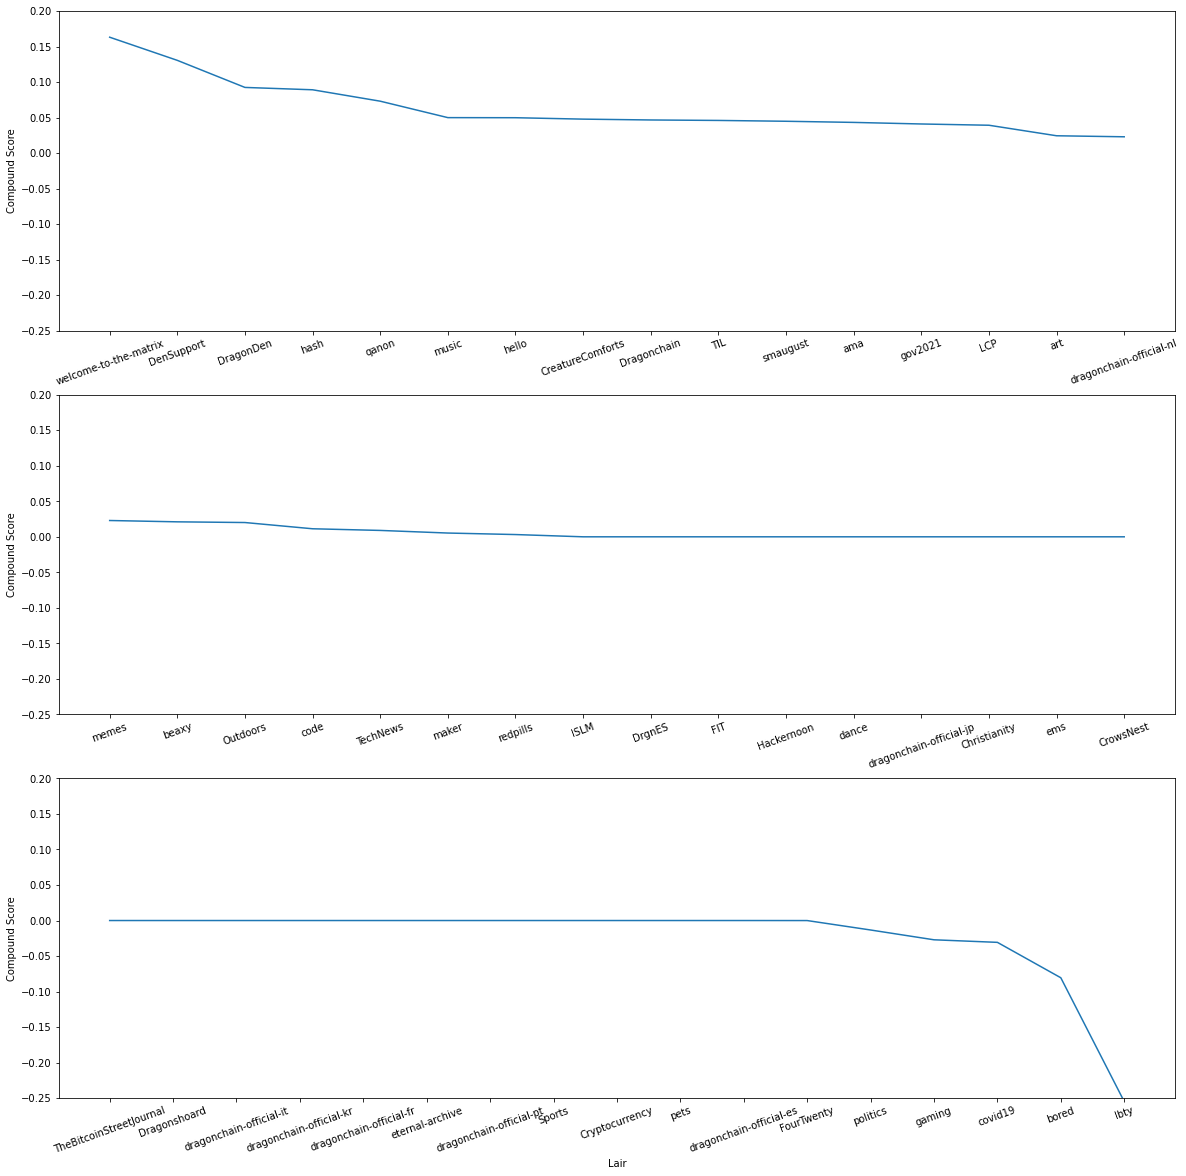

In [33]:
x = score_df['Name'].tolist()
y = score_df['Compound Score'].tolist()

x1= x[0:16]
x2 = x[16:32]
x3 = x[32:49]

y1= y[0:16]
y2 = y[16:32]
y3 = y[32:49]

fig, (ax1, ax2, ax3) = plt.subplots (3, figsize = (20,20))

ax1.plot(x1,y1)
ax1.set_ylim([-0.25, 0.2])
ax1.tick_params(axis='x', labelrotation = 20)
ax1.set_ylabel('Compound Score')

ax2.plot(x2,y2)
ax2.tick_params(axis='x', labelrotation = 20)
ax2.set_ylim([-0.25, 0.2])
ax2.set_ylabel('Compound Score')

ax3.plot(x3,y3)
ax3.tick_params(axis='x', labelrotation = 20)
ax3.set_ylim([-0.25, 0.2]);
ax3.set_ylabel('Compound Score')
ax3.set_xlabel('Lair');

It seems looking this that the most Positive Lair that Joe talks in is the Den Support Lair, and the most negative is the Beaxy Lair, so maybe we can look at what the most positive and negative comments there are in those lairs. 

### Here we can look closer at what the most positive comment was in the most positive lair

In [34]:
df = LairPostGetter('welcome-to-the-matrix')
df = df.loc[df['author_displayName']== 'J O E D R A G O N']
df = clean_comments(df['content'])
nltk_data_list = get_list(df)
sentiments = get_sentiments(nltk_data_list)
sentiments

,compound,neg,neu,pos,sentence
0,0.5106,0.000,0.736,0.264,i have always heard that a culture and team fit is important in the hrieg process
1,0.9201,0.066,0.507,0.427,based on his answers on super happy dragon lucky i tend to believe his origin story super insight and cuts to the chase


In [35]:
#### The most postive comment in the "welcome-to-the-matrix" Lair is

In [36]:
most_positive_index = sentiments['compound'].argmax()
sentiments.loc[[most_positive_index]]

,compound,neg,neu,pos,sentence
1,0.9201,0.066,0.507,0.427,based on his answers on super happy dragon lucky i tend to believe his origin story super insight and cuts to the chase


In [37]:
#### The most negative comment in the "welcome-to-the-matrix" lair

In [38]:
most_negative_index = sentiments['compound'].argmin()
sentiments.loc[[most_negative_index]]

,compound,neg,neu,pos,sentence
0,0.5106,0.0,0.736,0.264,i have always heard that a culture and team fit is important in the hrieg process


### No lets look at the the most negative Lair

In [39]:
df = LairPostGetter('lbty')
df = df.loc[df['author_displayName']== 'J O E D R A G O N']
df = clean_comments(df['content'])
nltk_data_list = get_list(df)
sentiments = get_sentiments(nltk_data_list)
sentiments

,compound,neg,neu,pos,sentence
0,0.0000,0.000,1.000,0.000,hehe
1,0.6946,0.038,0.845,0.116,we could spend the afternoon pulling sources google will not return many in search results but i do not have time right now public info can be found on bidens ukraine issues including audio recordings with energy companies and accused bribery joe is apparently indicted for crimes in the ukraine more importantly bidens family interests in china have also been documented with massive censorship in the media
2,0.7003,0.000,0.469,0.531,all hail our good dear leader comrade president biden
3,-0.0857,0.035,0.965,0.000,ah makes sense i wondered if it was an issue with the new year switch reason i asked is that i was considering to buy but then did not want to bid if i would have to wait for a year to see
4,0.0000,0.000,1.000,0.000,is the nft auction supposed to be 365 days long


In [40]:
most_positive_index = sentiments['compound'].argmax()
sentiments.loc[[most_positive_index]]

,compound,neg,neu,pos,sentence
2,0.7003,0.0,0.469,0.531,all hail our good dear leader comrade president biden


In [41]:
most_negative_index = sentiments['compound'].argmin()
sentiments.loc[[most_negative_index]]

,compound,neg,neu,pos,sentence
3,-0.0857,0.035,0.965,0.0,ah makes sense i wondered if it was an issue with the new year switch reason i asked is that i was considering to buy but then did not want to bid if i would have to wait for a year to see


#### What can we do further with this data?

Try to see if there was any correlation or similarities between users so that content was more viewable to like minded individuals

Try to do some sort of predictive analytics that would allow people who want to advertise to know which lair might be the most receptive.

We could do some sort of clustering of the topics and find our which topics are the most commonly talked about in each lair

We could find which topics are most negatively talked about or most positively talked about and add it to the weight of how viewable the content is

We could do this based on global or also for the user
